In [1]:
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv("/kaggle/input/isic-2019/ISIC_2019_Training_GroundTruth.csv")

In [3]:
df.head()

,image,MEL,NV,BCC,AK,BKL,DF,VASC,SCC,UNK
0,ISIC_0000000,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,ISIC_0000001,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,ISIC_0000002,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,ISIC_0000003,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,ISIC_0000004,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [4]:
# Count class distributions
class_counts = df.iloc[:, 1:].sum()
class_counts

MEL      4522.0
NV      12875.0
BCC      3323.0
AK        867.0
BKL      2624.0
DF        239.0
VASC      253.0
SCC       628.0
UNK         0.0
dtype: float64

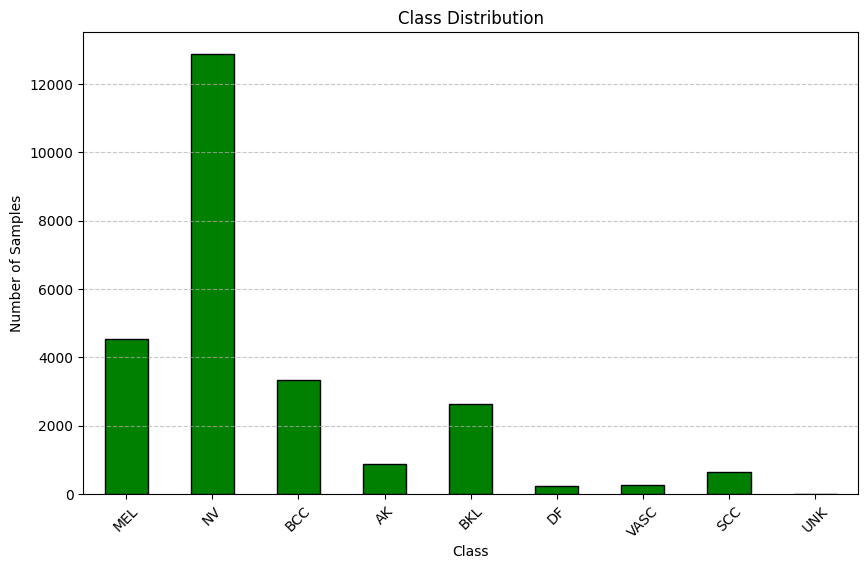

In [5]:
# Plot class distribution
plt.figure(figsize=(10, 6))
class_counts.plot(kind='bar', color='green', edgecolor='black')
plt.title('Class Distribution')
plt.xlabel('Class')
plt.ylabel('Number of Samples')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

In [6]:
pip install imbalanced-learn

Note: you may need to restart the kernel to use updated packages.


In [7]:
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler
import pandas as pd

# Drop 'UNK' column if it exists
if 'UNK' in df.columns:
    df = df.drop('UNK', axis=1)

# Ensure all columns are numeric
label_cols = df.columns[1:]
df[label_cols] = df[label_cols].apply(pd.to_numeric, errors='coerce')

# Handle missing values
df.dropna(inplace=True)  # Alternative: df.fillna(0, inplace=True)

# Convert one-hot encoded labels to a single class per row
df['label'] = df[label_cols].idxmax(axis=1)

# Ensure 'image' column exists
if 'image' not in df.columns:
    raise ValueError("The dataset must contain an 'image' column.")

# Count class distribution
class_counts = df['label'].value_counts()
majority_class = class_counts.idxmax()
majority_class_count = class_counts.max()

# Step-1: Undersample the majority class
undersample_ratio = 0.5  # Adjust as needed
undersample_strategy = {majority_class: int(undersample_ratio * majority_class_count)}

rus = RandomUnderSampler(sampling_strategy=undersample_strategy, random_state=42)
X_under, Y_under = rus.fit_resample(df[['image']], df['label'])

# Create a new DataFrame after undersampling
df_under = pd.DataFrame(X_under, columns=['image'])
df_under['label'] = Y_under

# Step-2: Oversample minority classes
class_counts_under = df_under['label'].value_counts()
new_majority_class_count = class_counts_under.max()

# Define oversampling strategy
sampling_strategy = {cls: new_majority_class_count for cls in class_counts_under.index}
ros = RandomOverSampler(sampling_strategy=sampling_strategy, random_state=42)

X_resampled, Y_resampled = ros.fit_resample(df_under[['image']], df_under['label'])

# Convert back to one-hot encoding
df_resampled = pd.DataFrame(X_resampled, columns=['image'])
one_hot_labels = pd.get_dummies(Y_resampled)

# Ensure all original labels exist in one-hot encoding
for col in label_cols:
    if col not in one_hot_labels.columns:
        one_hot_labels[col] = 0

# Merge back into final dataset
df_resampled = pd.concat([df_resampled, one_hot_labels], axis=1)

# Save the balanced dataset
df_resampled.to_csv('Balanced_Dataset.csv', index=False)
print('Balanced dataset saved successfully with full class balance.')

Balanced dataset saved successfully with full class balance.


New Class Distribution:
AK      6437
BCC     6437
BKL     6437
DF      6437
MEL     6437
NV      6437
SCC     6437
VASC    6437
dtype: int64


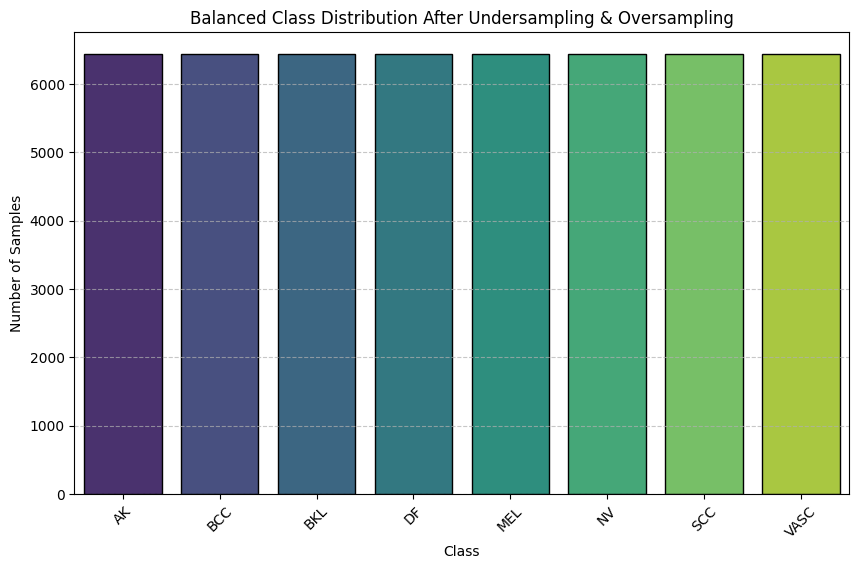

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns

# Count the new class distribution
new_class_counts = df_resampled.iloc[:, 1:].sum()

# Print new class distribution
print("New Class Distribution:")
print(new_class_counts)

# Bar Plot
plt.figure(figsize=(10, 6))
sns.barplot(x=new_class_counts.index, y=new_class_counts.values, palette="viridis", edgecolor="black")
plt.title("Balanced Class Distribution After Undersampling & Oversampling")
plt.xlabel("Class")
plt.ylabel("Number of Samples")
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)

In [9]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras import layers, models
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.utils.class_weight import compute_class_weight

In [10]:
base_dir = "/kaggle/input/isic-2019/ISIC_2019_Training_Input/ISIC_2019_Training_Input"
groundtruth_path = "/kaggle/working/Balanced_Dataset.csv"
labels = ['MEL', 'NV', 'BCC', 'AK', 'BKL', 'DF', 'VASC', 'SCC']
img_size = 224  
batch_size = 8
epochs = 10

In [11]:
groundtruth = pd.read_csv(groundtruth_path)
groundtruth['label'] = groundtruth[labels].idxmax(axis=1)

In [12]:
groundtruth.head()

,image,AK,BCC,BKL,DF,MEL,NV,SCC,VASC,label
0,ISIC_0024468,True,False,False,False,False,False,False,False,AK
1,ISIC_0024470,True,False,False,False,False,False,False,False,AK
2,ISIC_0024511,True,False,False,False,False,False,False,False,AK
3,ISIC_0024646,True,False,False,False,False,False,False,False,AK
4,ISIC_0024654,True,False,False,False,False,False,False,False,AK


In [13]:
file_paths = [os.path.join(base_dir, row['image'] + '.jpg') for _, row in groundtruth.iterrows()]
labels_indices = [labels.index(row['label']) for _, row in groundtruth.iterrows()]

In [14]:
# Split dataset
train_paths, temp_paths, train_labels, temp_labels = train_test_split(
    file_paths, labels_indices, test_size=0.4, random_state=42
)
val_paths, test_paths, val_labels, test_labels = train_test_split(
    temp_paths, temp_labels, test_size=0.5, random_state=42
)

# Convert labels to integer class indices (if needed)
val_labels = np.array(val_labels)
test_labels = np.array(test_labels)

In [15]:
print(f"Total Images: {len(file_paths)} images")
print(f"Training Set: {len(train_paths)} images ({len(train_paths) / len(file_paths) * 100:.2f}%)")
print(f"Validation Set: {len(val_paths)} images ({len(val_paths) / len(file_paths) * 100:.2f}%)")
print(f"Test Set: {len(test_paths)} images ({len(test_paths) / len(file_paths) * 100:.2f}%)")

Total Images: 51496 images
Training Set: 30897 images (60.00%)
Validation Set: 10299 images (20.00%)
Test Set: 10300 images (20.00%)


In [16]:
# Preprocessing Function
def preprocess_image(file_path, label):
    img = tf.io.read_file(file_path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, [img_size, img_size])
    img = img / 255.0  # Normalize to [0,1]
    return img, label

In [17]:
# Create TensorFlow Datasets
train_dataset = tf.data.Dataset.from_tensor_slices((train_paths, train_labels))
train_dataset = train_dataset.map(preprocess_image, num_parallel_calls=tf.data.AUTOTUNE)
train_dataset = train_dataset.shuffle(1024).batch(batch_size).prefetch(tf.data.AUTOTUNE)

val_dataset = tf.data.Dataset.from_tensor_slices((val_paths, val_labels))
val_dataset = val_dataset.map(preprocess_image, num_parallel_calls=tf.data.AUTOTUNE)
val_dataset = val_dataset.batch(batch_size).prefetch(tf.data.AUTOTUNE)

test_dataset = tf.data.Dataset.from_tensor_slices((test_paths, test_labels))
test_dataset = test_dataset.map(preprocess_image, num_parallel_calls=tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(batch_size).prefetch(tf.data.AUTOTUNE)

In [18]:
# Custom CNN Model
model = models.Sequential([
    layers.Conv2D(32, (3,3), activation='relu', input_shape=(img_size, img_size, 3)),
    layers.MaxPooling2D((2,2)),
    
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),

    layers.Conv2D(128, (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),

    layers.Flatten(),
    layers.Dense(512, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(len(labels), activation='softmax')  # Output for 8 classes
])


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [19]:
# Compile Model
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [20]:
# Train Model
history = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=10
)

Epoch 1/10
3863/3863 ━━━━━━━━━━━━━━━━━━━━ 206s 50ms/step - accuracy: 0.2612 - loss: 1.9193 - val_accuracy: 0.4799 - val_loss: 1.4038
Epoch 2/10
3863/3863 ━━━━━━━━━━━━━━━━━━━━ 153s 39ms/step - accuracy: 0.7656 - loss: 0.6590 - val_accuracy: 0.7984 - val_loss: 0.5694
Epoch 5/10
3863/3863 ━━━━━━━━━━━━━━━━━━━━ 149s 38ms/step - accuracy: 0.8216 - loss: 0.5069 - val_accuracy: 0.8156 - val_loss: 0.5436
Epoch 6/10
3863/3863 ━━━━━━━━━━━━━━━━━━━━ 146s 37ms/step - accuracy: 0.8626 - loss: 0.3917 - val_accuracy: 0.8351 - val_loss: 0.5286
Epoch 7/10
3863/3863 ━━━━━━━━━━━━━━━━━━━━ 145s 37ms/step - accuracy: 0.8870 - loss: 0.3243 - val_accuracy: 0.8429 - val_loss: 0.5471
Epoch 8/10
3863/3863 ━━━━━━━━━━━━━━━━━━━━ 145s 37ms/step - accuracy: 0.9113 - loss: 0.2556 - val_accuracy: 0.8530 - val_loss: 0.5419
Epoch 9/10
3863/3863 ━━━━━━━━━━━━━━━━━━━━ 209s 38ms/step - accuracy: 0.9212 - loss: 0.2292 - val_accuracy: 0.8570 - val_loss: 0.5864
Epoch 10/10
3863/3863 ━━━━━━━━━━━━━━━━━━━━ 146s 37ms/step - accuracy:

In [21]:
test_loss, test_accuracy = model.evaluate(test_dataset, verbose=0)
print(f"Loss on the test set: {test_loss:.4f}")
print(f"Accuracy on the test set: {test_accuracy:.4f}")

Loss on the test set: 0.5965
Accuracy on the test set: 0.8642


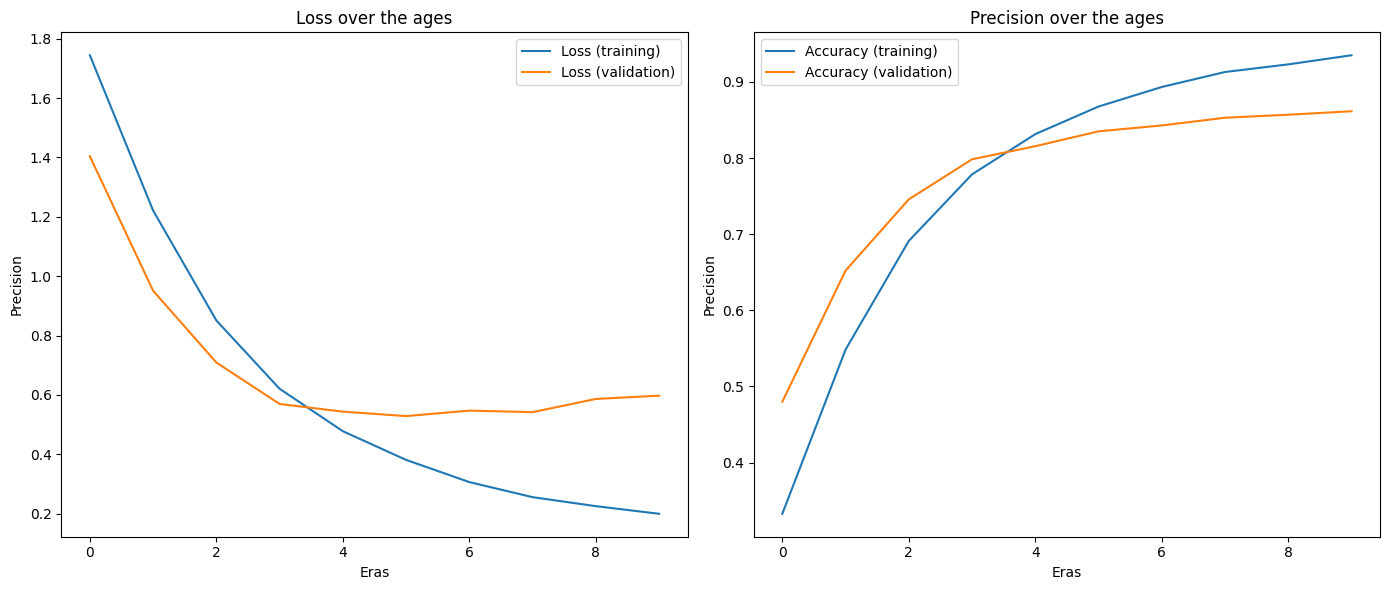

In [22]:
# Training curve
plt.figure(figsize=(14, 6))

# Loss curve
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Loss (training)')
plt.plot(history.history['val_loss'], label='Loss (validation)')
plt.title('Loss over the ages')
plt.xlabel('Eras')
plt.ylabel('Precision')
plt.legend()

# Precision curve
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Accuracy (training)')
plt.plot(history.history['val_accuracy'], label='Accuracy (validation)')
plt.title('Precision over the ages')
plt.xlabel('Eras')
plt.ylabel('Precision')
plt.legend()

plt.tight_layout()
plt.show()

In [23]:
y_true = np.concatenate([y for _, y in test_dataset], axis=0)
y_pred = np.concatenate([np.argmax(model.predict(x), axis=1) for x, _ in test_dataset], axis=0)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 280ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━

In [24]:
# Classification report
true_classes = np.unique(y_true)
print("\nClassification Report:\n")
print(classification_report(y_true, y_pred, target_names=[labels[i] for i in true_classes]))


Classification Report:

              precision    recall  f1-score   support

         MEL       0.67      0.70      0.69      1257
          NV       0.72      0.62      0.67      1237
         BCC       0.80      0.81      0.81      1295
          AK       0.95      0.99      0.97      1341
         BKL       0.79      0.78      0.78      1334
          DF       0.99      1.00      1.00      1286
        VASC       0.99      1.00      0.99      1306
         SCC       0.96      1.00      0.98      1244

    accuracy                           0.86     10300
   macro avg       0.86      0.86      0.86     10300
weighted avg       0.86      0.86      0.86     10300



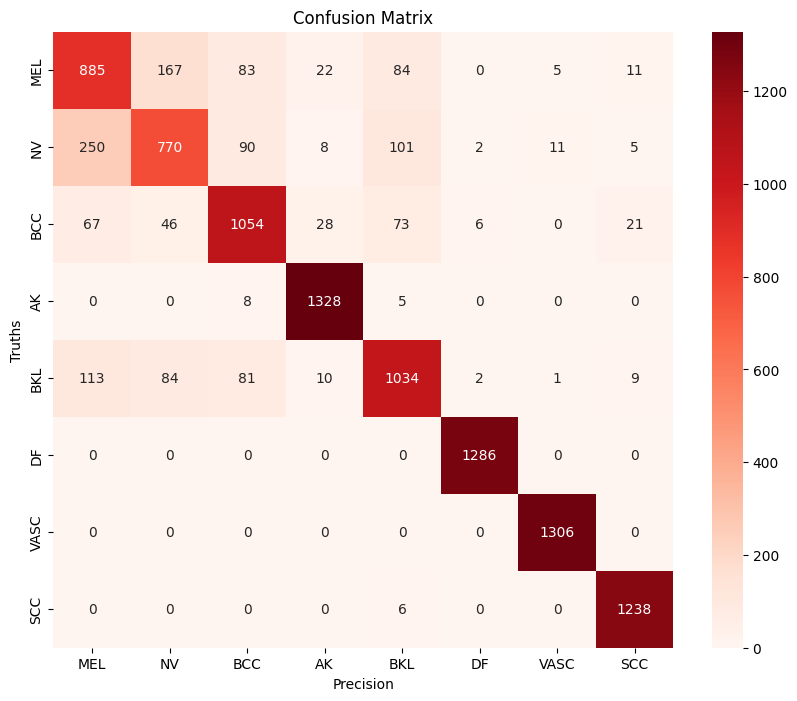

In [25]:
# Confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred, labels=true_classes)
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt="d", xticklabels=[labels[i] for i in true_classes],
            yticklabels=[labels[i] for i in true_classes], cmap="Reds")
plt.title("Confusion Matrix")
plt.xlabel("Precision")
plt.ylabel("Truths")
plt.show()

In [26]:
# Normalized confusion matrix
y_true = np.concatenate([y for _, y in test_dataset], axis=0)
y_pred = np.concatenate([np.argmax(model.predict(x), axis=1) for x, _ in test_dataset], axis=0)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━

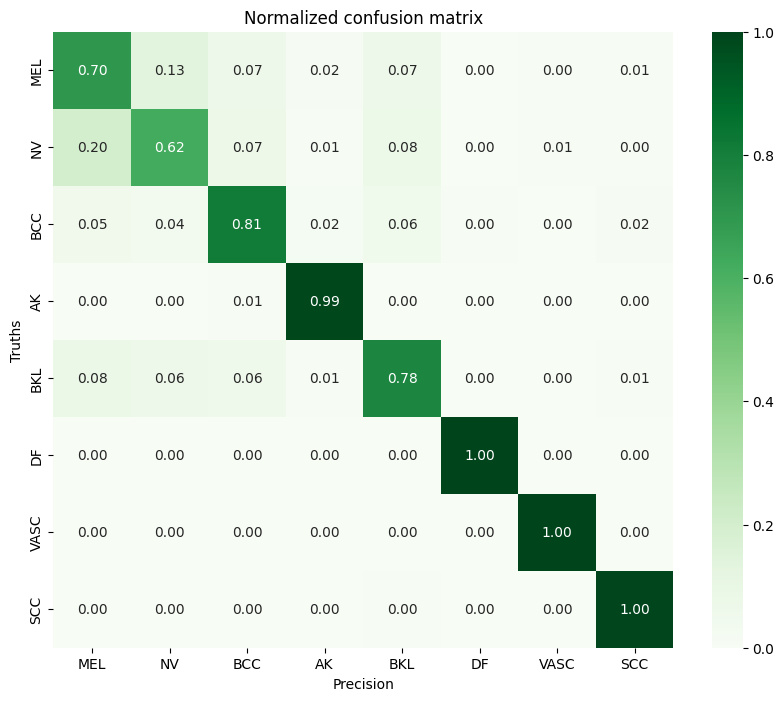

In [27]:
conf_matrix = confusion_matrix(y_true, y_pred, normalize="true")
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, cmap="Greens", fmt=".2f",
            xticklabels=labels, yticklabels=labels)
plt.title("Normalized confusion matrix")
plt.xlabel("Precision")
plt.ylabel("Truths")
plt.show()

In [28]:
from sklearn.preprocessing import label_binarize

# Binary class labels
y_true_bin = label_binarize(y_true, classes=range(len(labels)))

# Calculating model probability scores
y_pred_probs = model.predict(test_dataset, batch_size=batch_size)

1288/1288 ━━━━━━━━━━━━━━━━━━━━ 34s 26ms/step


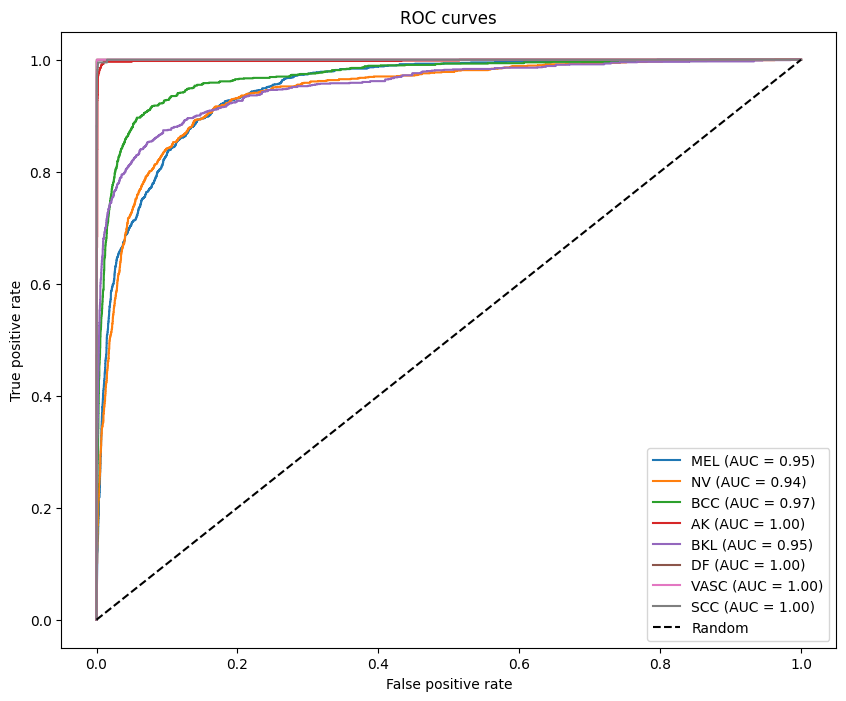

In [29]:
# Calculation of the ROC curve and AUC for each class
plt.figure(figsize=(10, 8))
for i in range(len(labels)):
    fpr, tpr, _ = roc_curve(y_true_bin[:, i], y_pred_probs[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f"{labels[i]} (AUC = {roc_auc:.2f})")

plt.plot([0, 1], [0, 1], 'k--', label="Random")
plt.title("ROC curves")
plt.xlabel("False positive rate")
plt.ylabel("True positive rate")
plt.legend()
plt.show()

In [30]:
import random
class_images = {i: [] for i in range(len(labels))}

In [31]:
# Group test images by their class
for path, label in zip(test_paths, test_labels):
    class_images[int(label)].append(path) 

In [32]:
# Select 4 random images per class
num_samples_per_class = 4
selected_images = []
true_labels = []

for class_label, images in class_images.items():
    selected = random.sample(images, num_samples_per_class) if len(images) >= num_samples_per_class else images
    selected_images.extend(selected)
    true_labels.extend([class_label] * len(selected))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 348ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━

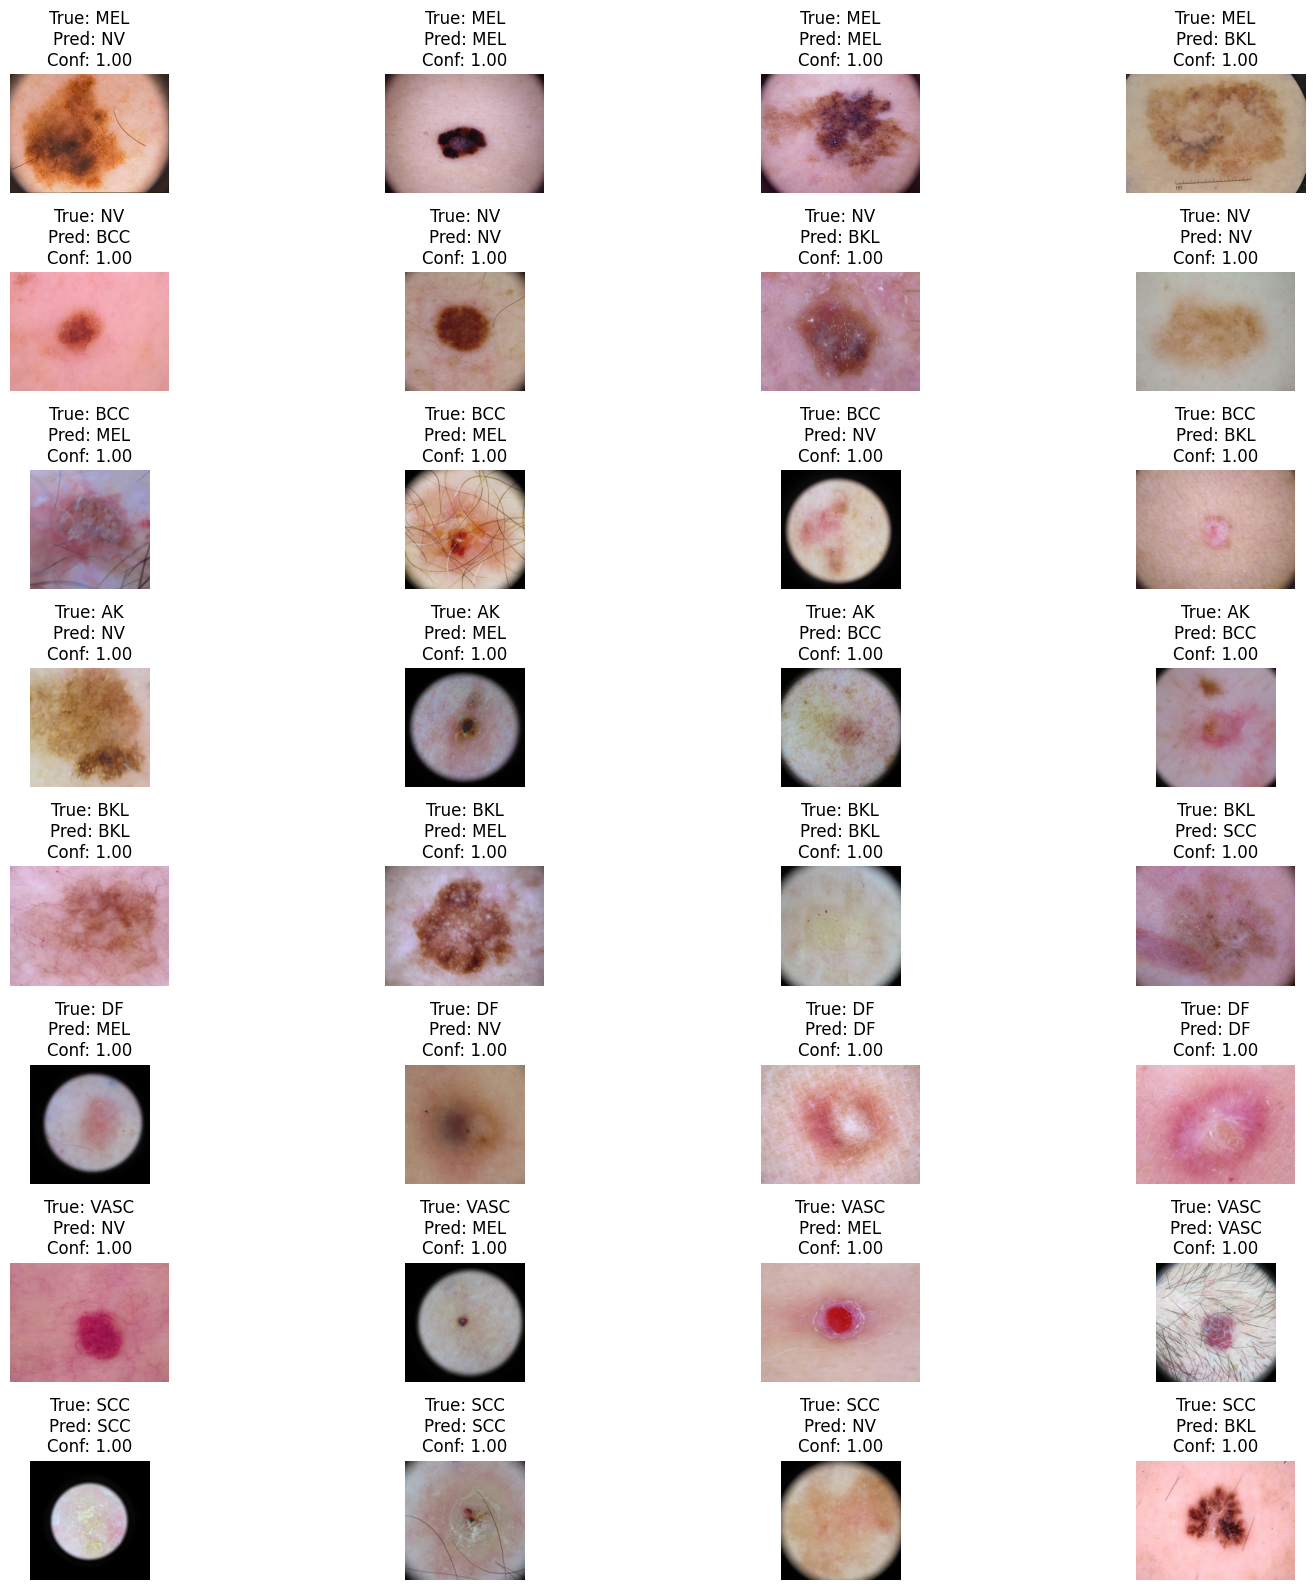

In [33]:
# Plotting setup
fig, axes = plt.subplots(8, 4, figsize=(16, 16))
axes = axes.flatten()

for i, (img_path, true_label) in enumerate(zip(selected_images, true_labels)):
    # Load and preprocess the image
    img = tf.io.read_file(img_path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, [img_size, img_size])
    img = tf.keras.applications.efficientnet.preprocess_input(img)
    
    # Expand dimensions for batch processing
    img_array = tf.expand_dims(img, axis=0)
    
    # Predict the class
    prediction = model.predict(img_array)
    predicted_class = np.argmax(prediction)
    confidence = np.max(prediction)
    
    # Display the image and predictions
    axes[i].imshow(tf.image.decode_jpeg(tf.io.read_file(img_path)).numpy())
    axes[i].axis("off")
    axes[i].set_title(f"True: {labels[true_label]}\nPred: {labels[predicted_class]}\nConf: {confidence:.2f}")

plt.tight_layout()
plt.show()